Before you read on, the note book is run in three sections, the reason for this is to conserve RAM, I only have access to 25GB (which I have easily blown through).

In [ ]:
pip install --upgrade tbb


In [ ]:
import numba
from numba import prange, njit, cuda
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation

# Euler forwards method (Explicit time stepping)

In the first section I will use the Euler forwards method, this amounts to implemntion the following system:

$
u^{(n + 1)}_{i,j} = u^{(n)}_{i,j} + \frac{\Delta t}{h^2}[u^{(n)}_{i + 1,j}, u^{(n)}_{i - 1,j} + u^{(n)}_{i,j + 1} + u^{(n)}_{i,j-1} -4u^{(n)}_{i,j}] = \Delta t Au^{(n)} + u^{n} = (1 + \Delta tA)^nu^{(0}
$

Where A is the two dimension laplacian operator $\Delta_{x,y}$.

The stability of this method requires that the largest Eigen value by magnitude be smaller than $\frac{\Delta t}{2} $ ie $\Delta t \lt \frac{2}{|\lambda|} $. Note that for a stable solution to exist there operator must have negative eigen values.

The region analyised has side length two in both dimesnions, the region is thus defined by $[-1,1] \times [-1,1]$ with spartial step size $h$ and temporal step size $\Delta t$.

Note that the temporal step size must be smaller than half the square of the spartial step size, $\Delta t \lt \frac{h^2}{2}$.

For the explict method I will update the temperature at the centre is 0.

An administrative  point is that the center of the grid is poorly defined, so for $N$ odd the center is $u_{\frac{N+1}{2},\frac{N+1}{2}}$ and for even $N$ I will consdier the average over the central 4 squres. For the sake of simplicity I will define $N$ as being odd integer. Note also that for even values of $N$ calling int((N+1)/2) rounds the grid position, for small grid sizes this will drastically alter the result but for large $N$ the effect will be neglegable.

In the first section I develope a simple parallel implementation and then two GPU schemes, the first being a copy of the CPU scheme and the second a vectorised alternative that makes use of the sparse CSR format and efficient MATVEC operations.

# CPU Explicit

This CPU implementation is simple in that I make no attempt to block or vectorise the operations. I assign a thread to each row of the grid and update them all at once using the previous iteration. If the new result depended on the current time step this approach would fail.

In [ ]:
def init_u(N,iterations):
  grid_dim = 2
  h =  grid_dim / (N - 1)

  dt = (h ** 2)/(4)
  gamma = (dt) / (h ** 2)

  # Initialize solution: the grid of u(k, i, j)
  u = np.empty((iterations, N, N))

  # Boundary conditions
  u_hot = 5

  # Set the initial condition
  u.fill(0)

  # Set the boundary conditions
  u[:, (N-1):, :] = u_hot
  return u, h, dt, gamma

#Define the parallel loop using prange
@numba.njit(parallel=True)
def calculate(u,N,gamma,k):
  for i in numba.prange(1, N-1):
    for j in range(1, N-1):
      #Update each grid element
      u[k + 1, i, j] = gamma * (u[k][i+1][j] + 
                                u[k][i-1][j] + 
                                u[k][i][j+1] + 
                                u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  return u

def get_results(N,iterations):
  #Initialise grid parameters
  u, h, dt, gamma = init_u(N) 
  #Initialise timer
  timer = 0 
  #Iterate 
  for k in range(0, iterations-1, 1):
    u = calculate(u, N, gamma,k)
    #If the centre is less that 1 increment the timer
    if u[k][int((N+1)/2)][int((N+1)/2)] < 1:
      timer += dt

  #Create an array of the central temperature over all iterations
  #This constitutes a full time evolution of the system.
  all_iters = [u[i][int((N+1)/2)][int((N+1)/2)] for i in range(iterations)]
  return u, all_iters, timer


I run the above code for 10 chosen dimensions and record the results. Using the CPU in this way and recording all of the iterations is very expensive in terms of RAM, hence I only go up to 201 by 201.



In [ ]:
iterations = 18000
R_1, all_iter_R_1, timer_R_1 = get_results(21,iterations)
R_2, all_iter_R_2, timer_R_2 = get_results(41,iterations)
R_3, all_iter_R_3, timer_R_3 = get_results(61,iterations)
R_4, all_iter_R_4, timer_R_4 = get_results(81,iterations)
R_5, all_iter_R_5, timer_R_5 = get_results(101,iterations)
R_6, all_iter_R_6, timer_R_6 = get_results(121,iterations)
R_7, all_iter_R_7, timer_R_7 = get_results(141,iterations)
R_8, all_iter_R_8, timer_R_8 = get_results(161,iterations)
R_9, all_iter_R_9, timer_R_9 = get_results(181,iterations)
R_10, all_iter_R_10, timer_R_10 = get_results(201,iterations)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Below is the highest dimensional example graphed. This is the result after 201 iterations.

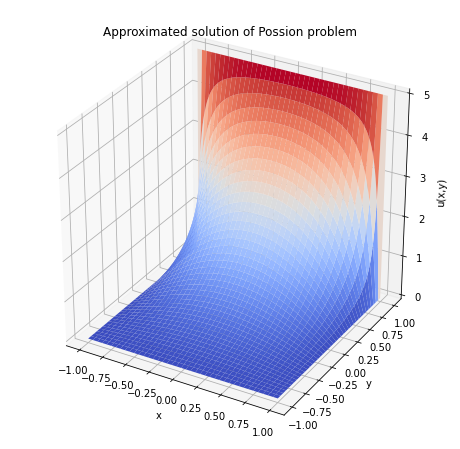

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#Create a new plot
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.gca(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, R_10.shape[1]) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, R_10[iterations - 1], 
                       antialiased=True, cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Approximated solution of Possion problem')
plt.show()


Below is a plot of the behavoiur of the scheme for dimensions 20 to 200. As we can see the smaller the value of N (the dimension) the fewer iterations are required for convergence. This is different to the amount of time required to converge since the time step dt is related to the grid size N.

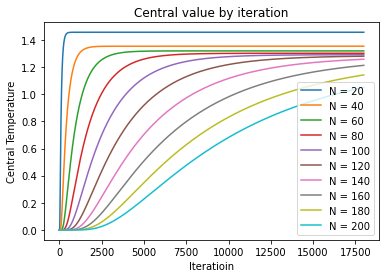

In [ ]:
plt.plot(np.arange(0,iterations,1),all_iter_R_1,label = 'N = 20')
plt.plot(np.arange(0,iterations,1),all_iter_R_2,label = 'N = 40')
plt.plot(np.arange(0,iterations,1),all_iter_R_3,label = 'N = 60')
plt.plot(np.arange(0,iterations,1),all_iter_R_4,label = 'N = 80')
plt.plot(np.arange(0,iterations,1),all_iter_R_5,label = 'N = 100')
plt.plot(np.arange(0,iterations,1),all_iter_R_6,label = 'N = 120')
plt.plot(np.arange(0,iterations,1),all_iter_R_7,label = 'N = 140')
plt.plot(np.arange(0,iterations,1),all_iter_R_8,label = 'N = 160')
plt.plot(np.arange(0,iterations,1),all_iter_R_9,label = 'N = 180')
plt.plot(np.arange(0,iterations,1),all_iter_R_10,label = 'N = 200')
plt.ylabel('Central Temperature')
plt.xlabel('Iteratioin')
plt.title('Central value by iteration')
plt.legend(loc="best")
plt.show()

Lower grid resolutions converge to equlibrium much faster than and much less acuratly than those with higher resolutions. This is because the temporal and spartial step sizes are ralted to the size of the grid. The lower resolution calls all settle on a higher central temperature that the more detailed calls. This is because the footprint of the central point is much larger, hence the influence from the hot side is exagerated for small grid sizes.

Below we see the time taken for the central point to reach a temperature greater than 1 increases with the resolution of the mesh but converges to the true value from below.

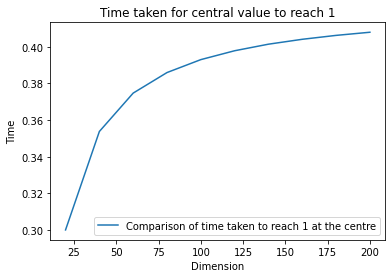

In [ ]:
times = [timer_R_1,timer_R_2,
         timer_R_3,timer_R_4, 
         timer_R_5,timer_R_6,
         timer_R_7,timer_R_8,
         timer_R_9,timer_R_10]

plt.plot(np.arange(20,220,20), 
         times,label = 'Comparison of time taken to reach 1 at the centre')

plt.ylabel('Time')
plt.xlabel('Dimension')
plt.title('Time taken for central value to reach 1')
plt.legend(loc="best")
plt.show()

By subtracting all the calculated times from the true value we more clearly see the rate of convergence and its realationship to the dimension.

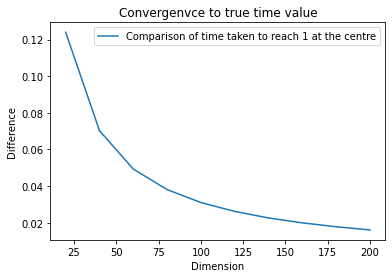

In [ ]:
#Convergence to final answer:
true_value = 0.424011387033
times_norm = np.zeros(len(times))
for i in range(len(times)):
  times_norm[i] = true_value - times[i]
  
plt.plot(np.arange(20,220,20), 
         times_norm,label = 'Comparison of time taken to reach 1 at the centre')

plt.ylabel('Deviation from true value')
plt.xlabel('Dimension')
plt.title('Convergenvce to true time value')
plt.legend(loc="best")
plt.show()

# GPU Explicit

For the GPU implementation I will use a kernel executing the same function used in compute above. The only difference is that the grid u is flattened into a vector so that every point can be updated simultaneously.

Note that its not optimal to copy the data back to host after every iteration, but in order to record all iterations on the GPU it has to be done.

In [ ]:
@cuda.jit
def GPU_ker(u_gpu,v_gpu,gamma):
  #Specify local shared memory type and size
  local_v = cuda.shared.array((SX),numba.float32)
  local_u = cuda.shared.array((SX),numba.float32)
  
  #Load all the needed data and indicies into local memory
  local_u = u_gpu
  #Initialise local_v to local_u, I will swap the values at the end of the kernel.
  local_v = v_gpu 
  
  #Define local thread location 
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x

  #Define global thread location
  j = SX * bx + tx

  #Sync threads before operations begin
  cuda.syncthreads()


  if j != 0 and j != N - 1: #Dont update boundary points
    for i in range(1,N-1):
      local_v[j * N + i] = gamma * (local_u[(j - 1)*N + i]
                                    + local_u[(j + 1)*N + i] 
                                    + local_u[j*N + i-1] 
                                    + local_u[j*N+ i+1] 
                                    - 4*local_u[j * N + i]) + 
                                    local_u[j * N + i]
  #Sync threads after operations begin prior to looped call
  cuda.syncthreads()

#Set parameter values and call kernel
def call_gpu(N, iterations):
  recorder = []
  u, h, dt, gamma = init_u(N)
  v = u[0].reshape(N**2)
  u = u[0].reshape(N**2)
  
  nblocks = (N + SX - 1) // SX
  
  #Send initial grid values to the GPU 
  #u_gpu = cuda.to_device(u)
  v_gpu = cuda.to_device(v)
  recorder = []
  timer = 0
  for k in range(iterations):
    u_gpu = cuda.to_device(u)
    GPU_ker[(nblocks,1),(SX,1)](u_gpu,v_gpu,gamma)
    u = v_gpu.copy_to_host()
    recorder.append(u)

    if recorder[k].reshape(N,N)[int((N+1)/2)][int((N+1)/2)] < 1:
      timer += 1
  u = u.reshape(N,N)
  return recorder, timer

In [ ]:
#Define the resolution
N = 151
#Define the iterations
iterations = 25000
#Define the block size
SX = 32
#make GPU call and record results.
recorder, timer = call_gpu(N, iterations)

In [ ]:
#redefine the spartial seperation h and temporal seperation dt
h = 1/(N - 1)
dt = (h ** 2)

In [ ]:
timer, timer*dt

(9068, 0.4030222222222223)

It takes 9068 iterations, or 0.40302 seconds for a grid of this size to reach a central temperature of 1. This is not far from the true number but we can do better.

Once more I demonstrate the 3d graphic for the temperature distribution below.

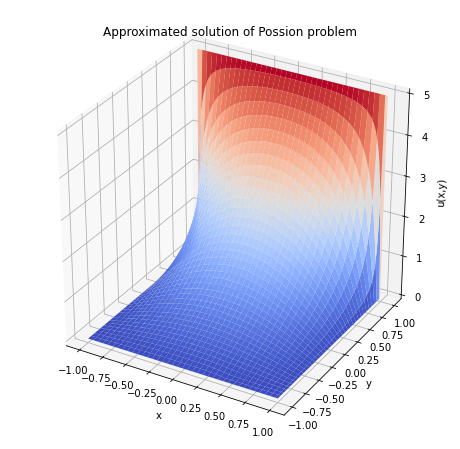

In [ ]:
%matplotlib inline

#Create a new plot
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.gca(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, N) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, recorder[iterations-1].reshape(N,N), 
                       antialiased=True, 
                       cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Approximated solution of Possion problem')
plt.show()

# Improved Explicit

A more effective version of the GPU implementation could use the CSR sparse matrix format and a matvec kernel. This has the advantage of reducing the amount of ram used, being faster to compute and making better use of the GPU architecture.

The sparse matrix structure follows from 
$
u^{(n + 1)}_{i,j} = u^{(n)}_{i,j} + \frac{\Delta t}{h^2}[u^{(n)}_{i + 1,j}, u^{(n)}_{i - 1,j} + u^{(n)}_{i,j + 1} + u^{(n)}_{i,j-1} -4u^{(n)}_{i,j}] = \Delta t Au^{(n)} + u^{n} = (1 + \Delta tA)^nu^{(0}
$

This means that there are ones along the diagonals for boundary points, and $1 - 4 \gamma, \gamma = \frac{\Delta t}{h^2}$ for the interior points. Additionally each interior point has four contributions from their surroundings, corresponding to four matrix elements with values $\gamma$.

In [ ]:
from scipy.sparse import coo_matrix

def discretise_operator(N,iterations):

    #define parameters
    nelements = 5 * N**2 - 16 * N + 16
    u, h, dt, gamma = init_u(N, iterations)
    row_ind = np.empty(nelements, dtype=np.float64) 
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    #initialise count
    count = 0
    for j in range(N):
        for i in range(N):
          #boundaries
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
              #Boundaries are diagonal
                row_ind[count] = col_ind[count] = j * N + i
                #Boundaries are preserves by identity
                data[count] =  1
                count += 1
                
                #interior points
            else:
              #Iterate one row at a time
                row_ind[count : count + 5] = j * N + i
                #define column indicies for each points contributions
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                #diagonal elements are 1 - 4*gamma
                data[count] = 1 - 4*gamma
                data[count + 1 : count + 5] = gamma
                
                count += 5
                                                
    return coo_matrix((data, 
                       (row_ind, col_ind)), 
                      shape=(N**2, N**2)).tocsr(), 
                      u, h, dt, gamma

Using a grid size of 291 by 291 I test the second kernel against the know results and try to find the true time value as accurately as possible.
Infact I obtain accuracy to four decimal places, which was computed in under 5 minutes. Higher accuracy could easily be obtains but I am limited by the RAM I have access to.

In [ ]:
N = 291  #Set grid size
iterations = 37000
A, u, h, dt, gamma = discretise_operator(N,iterations) #Discretise the system
#Define dummy array for global buffer
v = np.zeros(N**2).astype('float32')

#Define starting values of u_0 as above for global buffer
u = np.zeros(shape = N**2) 

# Boundary conditions
u_hot = 5

# Set the initial condition
u.fill(0)

# Set the boundary conditions
u.reshape(N,N)[(N-1):, :] = u_hot

In [ ]:
#Create Au kernel 
from numba import cuda
SX = 512
SY = 4*(N-1)+5*(N-2)**2
nblocks = (N**2 + SX -1) // SX

@cuda.jit
def GPU_ker(n_row, data , indices, indptr, u_gpu, v_gpu, iters):
  #Specify local shared memory type and size
  local_v = cuda.shared.array((SX),numba.float32)
  local_u = cuda.shared.array((SX),numba.float32)
  local_data = cuda.shared.array((SY),numba.float32)
  local_indices = cuda.shared.array((SY),numba.int32)
  local_indptr = cuda.shared.array((SY),numba.int32)

  #Load all the needed data and indicies into local memory
  local_v = v_gpu
  local_u = u_gpu
  local_data = data
  local_indices = indices
  local_indptr = indptr

  #Define local thread location 
  tx = cuda.threadIdx.x
  bx = cuda.blockIdx.x

  #Define global thread location
  row = SX * bx + tx

  #Sync threads before operations begin
  cuda.syncthreads()

### CSR MATVEC SCHEME ###


  #Remain in bounds
  if row < n_row:
    #Initialise dummy value for each row
    tmp = 0.

    #Set starting column cs and end column ce, 
    #these are all columns with none zero values for the given row.
    cs = indptr[row]
    ce = indptr[row+1]

    #For each row evaluate the linear system on only the none zero columns
    for c in range(cs,ce):
      tmp += local_data[c] * local_u[indices[c]]
    #Save data in local memory
    local_v[row] = tmp 

    cuda.syncthreads()

I call the above kernal multiple times to update the values, recording each as I go. I then compare these and use them to find the time taken for the central temperature to exceed 1.

In [ ]:
#Initialise storage array
a = []
#define iterations
iters = iterations
#Assign first global buffer to device memory
v_gpu = cuda.to_device(v)
for i in range(iters):
  #Assign second global buffer to device memory
  u_gpu = cuda.to_device(u)
  #Call the kernel
  GPU_ker[(nblocks,1),(SX,1)](u.shape[0], 
                              A.data, 
                              A.indices, 
                              A.indptr, 
                              u_gpu, 
                              v_gpu, 
                              iters)
  #Update second global buffer and reapeat.
  u = v_gpu.copy_to_host()
  #Append grid to storage array.
  a.append(u)

Next I find the time taken by finding the iterations taken for the temperature in the middle to reach 1, then I multiply by the size of the time step.

In [ ]:
timer_2 = 0
for i in range(iters):
  if a[i][N**2//2] < 1:
    timer_2 += 1

In [ ]:
a[timer_2][N**2//2]

1.000006

In [ ]:
timer_2, timer_2 * dt

(35658, 0.42400713436385257)

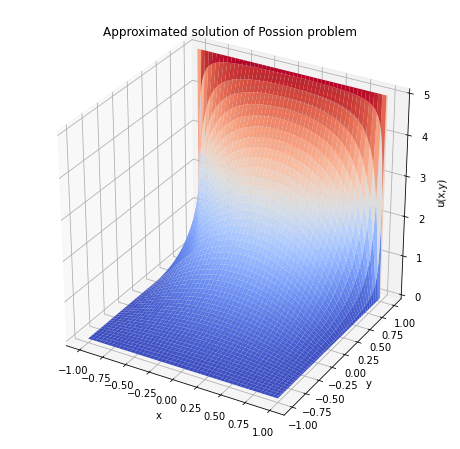

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm

#Create a new plot
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.gca(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, N) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, a[-1].reshape(N,N), 
                       antialiased=True, 
                       cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Approximated solution of Possion problem')
plt.show()

# Euler Backwards (Implicit time stepping)

The backwards euler method is similar to the forwards version, the main difference is that the rate of change depends on the next iteration, not only the previous ones. It is possible to obtain a system of the form $Ax = b$ where $A$ is the operator $(1+\frac{4\Delta t}{h^2} - \frac{\Delta t}{h^2}\Delta)u^{(k+1)} = u^{(k)}$. A scipy sparse solver can be used to find $A^{-1}$ which is the matrix that evloves the system forwards in time. The advantage of the implicit version is that it is always stable, but at the cost of often being difficult to implement.

The matrix format is penta-diagonal with the non zero elements of the form: $
[0,...,0, \gamma, 0, 0,\gamma, \alpha, \gamma, 0, 0, \gamma, 0, ..., 0]
$ for operator elements corresponding to interior points and 1 on the diagonal for the boundary points in order to prevent the BCs from being updated.

Below I design a CSR format matrix for A and use the spsolve direct solver from sci py to find the evolution matrix.

In [ ]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import coo_matrix

#N:Dimension of grid funf: negative laplacian function fung:boundary condition
def implicit(N): 
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16 #Find the number of non zero elements.
    h = 1/(N + 1) #Define grid size, this is 2 greater than the true grid due 
                  #to the inclusion of BCs in the operator.
    dt = (h ** 2)/(4) #Define dt
    alpha = 1 + 4*dt/(h**2) #Define alpha
    gamma = dt/(h**2) #Define gamma
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = alpha
                data[count + 1 : count + 5] = - gamma

                
                count += 5
    #Return a sparse matrix with the column and row indicies found above.                                            
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr()

In [ ]:
#Initialise the grid and matricies.
N = 80
iterations = 1000
u, h, dt, gamma = init_u(N, iterations)
u = u[0].reshape(N**2)
A = implicit(N)

To iterate this scheme I use a sparse solver to reapeatedly solve for $x$ and then I substitute the updated $x$ back into the system and repeat. This takes much longer than the other schemes I have demonstrated. The backwards euler method is, however, always stable. Whereas the forwards euler has very specific criteria for stability which is limited by its dominant eigen values.

In [ ]:
x = u
recorder_imp = []
iterations = 5000
for i in range(iterations):
  x = spsolve(A, x)
  recorder_imp.append(x.reshape(N,N))

In [ ]:
#Find the time taken to reach 1. 
timer_3 = 0
for i in range(iterations):
  if recorder_imp[i][int((N+1)/2)][int((N+1)/2)] < 1:
    timer_3 += dt

In [ ]:
timer_3

0.4039416760134675

we can clearly accuratly calculate the amount of time taken for the centre of the grid to reach 1, but the time taken to inverse this sparse matrix means a significant amount more time is taken performing the actual calcuation. Since this overhead comes from the use of a sparse solver there is little that can be done about it.

As we can see below the scheme converges to the correct graph, as with the explicit GPU and CPU implementations.

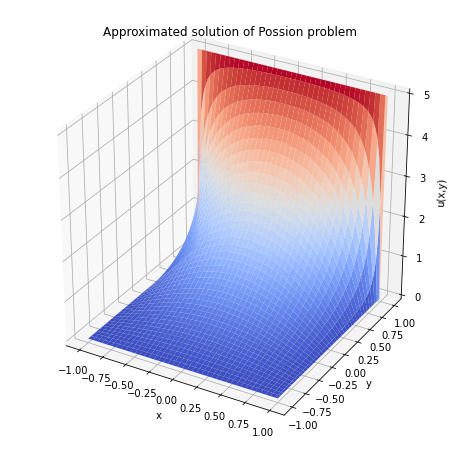

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#Create a new plot
fig = plt.figure(figsize=(8, 8)) 
#Define the type of figure
ax = fig.gca(projection='3d') 
#Create axes
ticks= np.linspace(-1, 1, N) 
X, Y = np.meshgrid(ticks, ticks) 
#Define surface
surf = ax.plot_surface(X, Y, x.reshape(N,N), antialiased=True, 
                       cmap=cm.coolwarm) 
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x,y)')
ax.set_title('Approximated solution of Possion problem')
plt.show()
